# Experiments for fine tuning a pre-trained CNN for sensor processing

VGG-11 has a latent space of 512. How do we reduce / expand this to the latent space we want???

* Idea 0: just use the features as it is
* Idea 1: fine tune on proprioception


## Extracting the VGG-19 features from some pictures from a task

In [1]:
import sys
sys.path.append("..")
from settings import Config

from pathlib import Path
from behavior_cloning.demo_to_trainingdata import BCDemonstration

import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

# Step 1: Load the pre-trained VGG-19 model
vgg19 = models.vgg19(pretrained=True)
vgg19.eval()  # Set the model to evaluation mode

/apps/anaconda/anaconda-2023.09/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/apps/anaconda/anaconda-2023.09/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [4]:
run = "vgg19_128"
exp = Config().get_experiment("sensorprocessing_propriotuned_cnn", run)
# model_subdir = Path(exp["data_dir"], exp["model_dir"], "models", exp["model_name"], exp["model_subdir"])
# conv_vae_jsonfile = Path(model_subdir, "config.json")


No system dependent experiment file
 /home/ssheikholeslami/SaharaBerryPickerData/experiments-Config/sensorprocessing_propriotuned_cnn/vgg19_128_sysdep.yaml,
 that is ok, proceeding.
Configuration for experiment: sensorprocessing_propriotuned_cnn/vgg19_128 successfully loaded


In [5]:
task = "random-uncluttered"
demos_dir = Path(Config()["demos"]["directory"])
task_dir = Path(demos_dir, "demos", task)
for demo_dir in task_dir.iterdir():
    if not demo_dir.is_dir():
        pass


# These are the transforms that the image to what vgg-19 was trained on
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Normalization for ImageNet
        std=[0.229, 0.224, 0.225]
    )
])

bcd = BCDemonstration(demo_dir, sensorprocessor=None)
for i in range(1, bcd.maxsteps-1):
    imgtensor, image = bcd.get_image(i, transform=transform)

Cameras found: ['dev2']
There are 372 steps in this demonstration
This demonstration was recorded by the following cameras: ['dev2']


In [6]:
print(imgtensor)

tensor([[[[-1.0904, -1.0219, -0.9877,  ...,  0.0227,  0.0912,  0.0569],
          [-1.1760, -1.0733, -1.0562,  ..., -0.0116, -0.0801, -0.2171],
          [-1.1075, -1.1418, -1.1760,  ..., -0.3712, -0.5596, -0.8164],
          ...,
          [ 0.2282,  0.2453,  0.2624,  ..., -1.9638, -1.9467, -1.9638],
          [ 0.1768,  0.2282,  0.2453,  ..., -1.9809, -1.9295, -1.9295],
          [ 0.1426,  0.2111,  0.2453,  ..., -1.9638, -1.9467, -1.9638]],

         [[-0.7052, -0.6176, -0.5476,  ...,  0.8004,  0.8529,  0.8179],
          [-0.7752, -0.6702, -0.6352,  ...,  0.6604,  0.5553,  0.3803],
          [-0.6527, -0.6877, -0.7227,  ...,  0.0826, -0.1625, -0.4426],
          ...,
          [ 0.2227,  0.2402,  0.2927,  ..., -1.8782, -1.8606, -1.8782],
          [ 0.2752,  0.3277,  0.2927,  ..., -1.8957, -1.8256, -1.8081],
          [ 0.2927,  0.3452,  0.3452,  ..., -1.8782, -1.8256, -1.8431]],

         [[-0.0964, -0.1835, -0.2881,  ...,  1.4025,  1.4200,  1.3502],
          [-0.2010, -0.2010, -

In [7]:
imgtensor.dtype

torch.float32

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg19.to(device)

feature_extractor = vgg19.features
#result = vgg19(imgtensor)
result = feature_extractor(imgtensor)
result.shape


torch.Size([1, 512, 7, 7])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


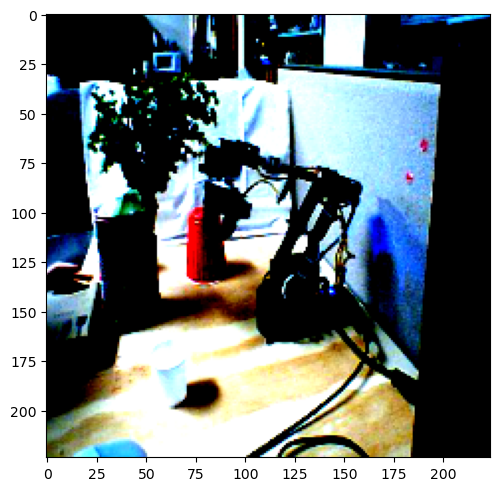

In [9]:
fig, axs = plt.subplots(1,1, constrained_layout=True)
axs.imshow(image)

In [10]:
class VGG19Embedding(nn.Module):
    def __init__(self, latent_size):
        super(VGG19Embedding, self).__init__()
        self.feature_extractor = vgg19.childrenfeatures
        self.flatten = nn.Flatten()  # Flatten the output for the fully connected layer
        self.fc = nn.Linear(512 * 7 * 7, latent_size)  # Adjust input size based on VGG19 output size

    def forward(self, x):
        # Extract features
        features = self.feature_extractor(x)
        # Flatten the feature map
        features_flat = self.flatten(features)
        # Project to the latent space
        latent = self.fc(features_flat)
        return latent

In [11]:
# Define the MLP regression model
class VGG19Regression(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VGG19Regression, self).__init__()
        vgg19 = models.vgg19(pretrained=True)
        self.feature_extractor = vgg19.childrenfeatures
        self.flatten = nn.Flatten()  # Flatten the output for the fully connected layer
        self.model = nn.Sequential(
            nn.Linear(512 * 7 * 7, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
        # freeze the parameters
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = self.feature_extractor(x)
        flatfeatures = self.flatten(features)
        return self.model(flatfeatures)

In [12]:
sp = sp_conv_vae.get_sp_of_conv_vae_experiment("vae_01")

task = exp["proprioception_training_task"]
proprioception_input_file = Path(exp["data_dir"],
                                            exp["proprioception_input_file"])
proprioception_target_file = Path(exp["data_dir"],
                                            exp["proprioception_target_file"])

# FIXME: this is going to be different, because we are going to be working on the original pictures, not on the extracted values

tr = load_demonstrations_as_proprioception_training(sp, task,
                                                    proprioception_input_file, proprioception_target_file)
inputs_training = tr["inputs_training"]
targets_training = tr["targets_training"]
inputs_validation = tr["inputs_validation"]
targets_validation = tr["targets_validation"]

# Initialize model, loss function, and optimizer
input_size = inputs_training.size(1)
hidden_size = 64
output_size = targets_training.size(1)

print(input_size)
print(output_size)

model = MLPRegression(input_size, hidden_size, output_size)
# criterion = nn.MSELoss()
# Experiment: would this be better???
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

NameError: name 'sp_conv_vae' is not defined